In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from pandas.plotting import parallel_coordinates
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6)

In [58]:
# Load the dataset
url = "https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv"
df = pd.read_csv(url)

In [59]:
# Data Shape
df.shape

(200, 5)

In [60]:
# Preview data
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [61]:
# Descriptive statistics
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


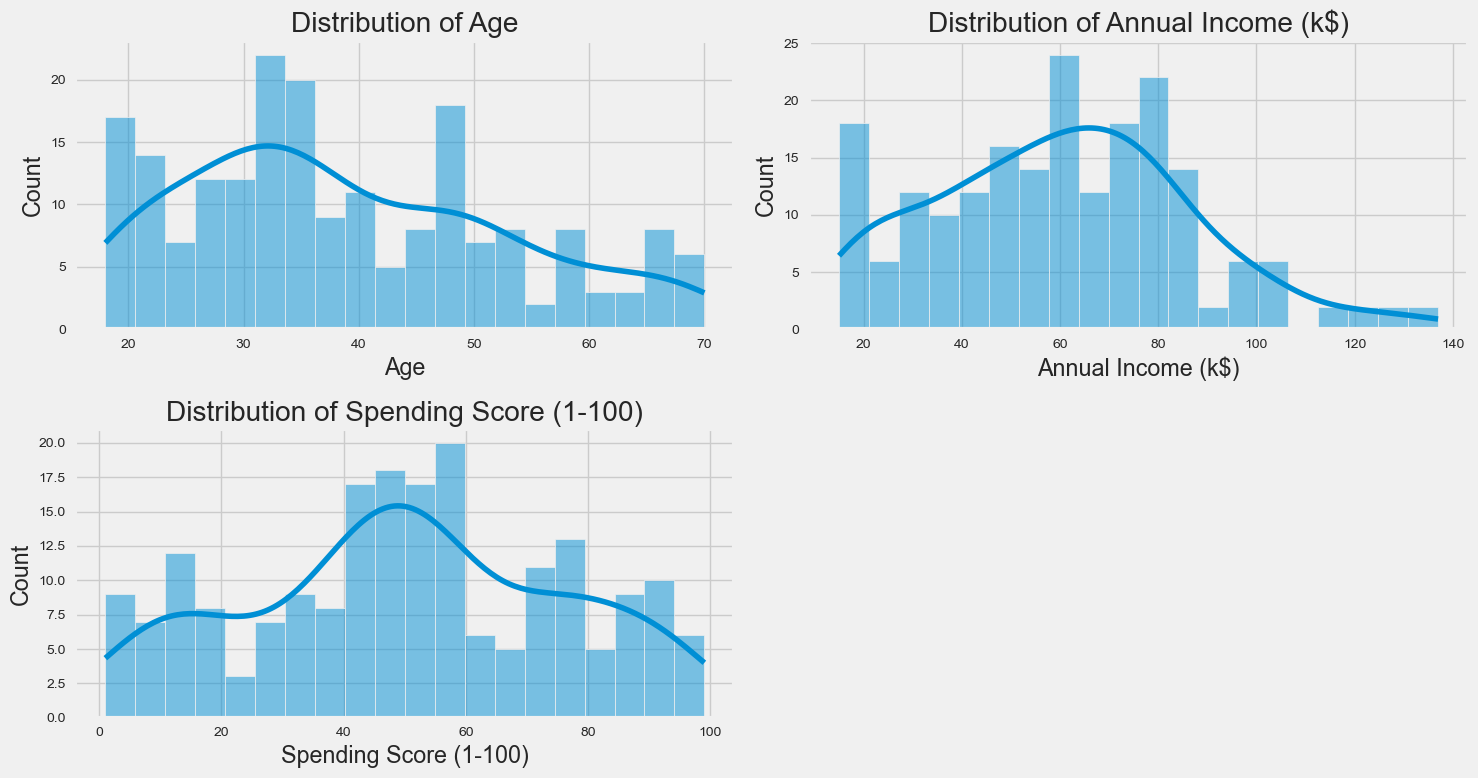

In [62]:
# Visualize distributions
plt.figure(figsize=(15, 8))
for i, col in enumerate(['Age', 'Annual Income (k$)', 'Spending Score (1-100)']):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

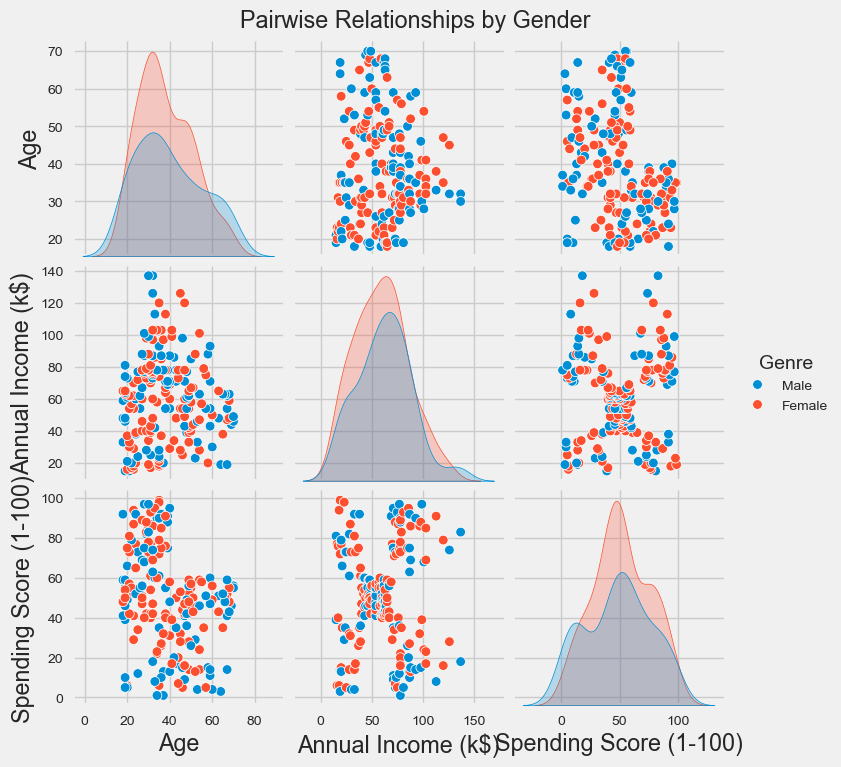

In [71]:
# Pairplot for relationships
sns.pairplot(df.drop('CustomerID', axis=1), hue="Genre" ,diag_kind='kde')
plt.suptitle('Pairwise Relationships by Gender', y=1.02)
plt.show()

In [83]:
# Data Preprocessing
print("Original columns:", df.columns.tolist())

Original columns: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


In [84]:
# Identify correct column names
income_col = 'Annual Income (k$)' if 'Annual Income (k$)' in df.columns else 'Annual Income'
spending_col = 'Spending Score (1-100)' if 'Spending Score (1-100)' in df.columns else 'Spending Score'
gender_col = 'Gender' if 'Gender' in df.columns else 'Genre'

In [85]:
# Select features
numeric_features = ['Age', income_col, spending_col]
X = df[numeric_features + [gender_col]].copy()

In [86]:
# Handle categorical variable
X = pd.get_dummies(X, columns=[gender_col], drop_first=True, prefix='Gender')

In [87]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

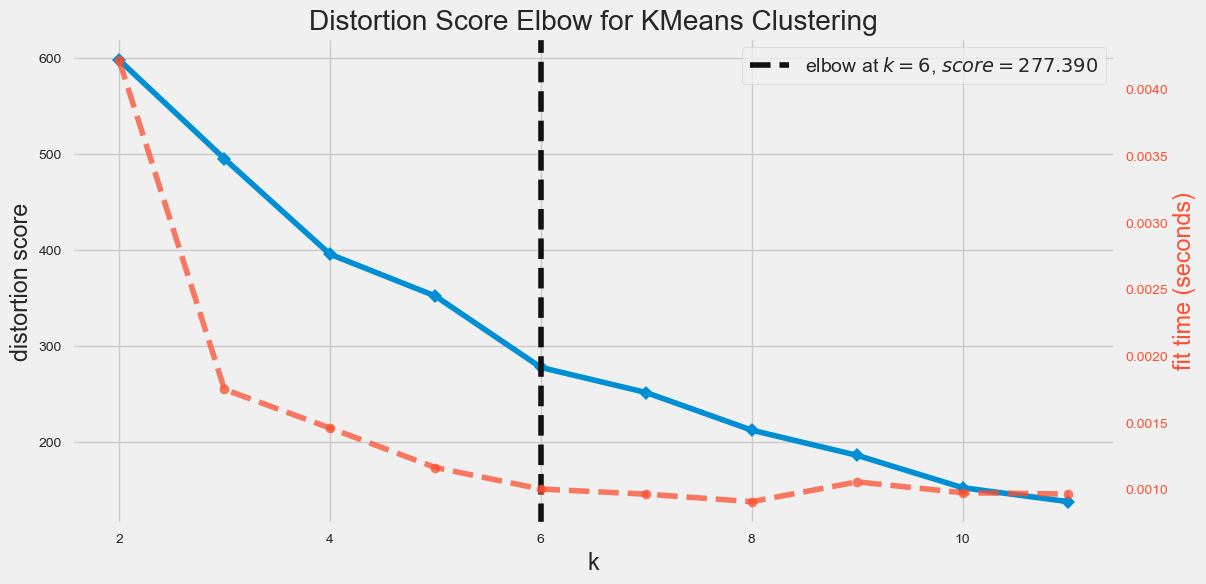

In [89]:
# Elbow method to find optimal k
plt.figure(figsize=(12, 6))
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2, 12))
visualizer.fit(X_scaled)
visualizer.show()
plt.show()

For n_clusters = 2, the silhouette score is 0.278
For n_clusters = 3, the silhouette score is 0.258
For n_clusters = 4, the silhouette score is 0.290
For n_clusters = 5, the silhouette score is 0.272
For n_clusters = 6, the silhouette score is 0.335
For n_clusters = 7, the silhouette score is 0.346


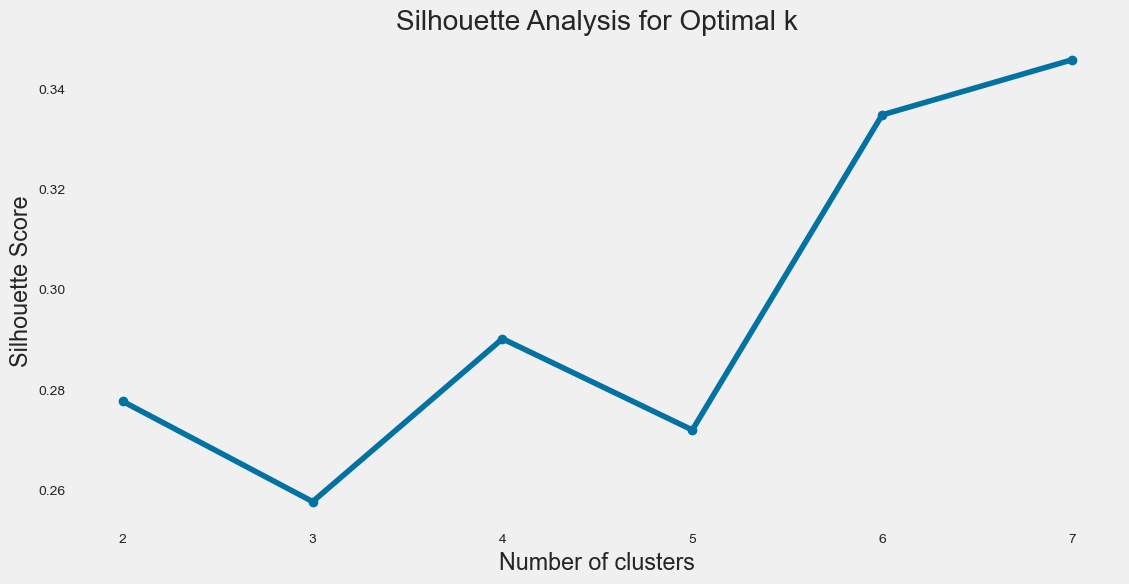

In [90]:
# Silhouette analysis
range_n_clusters = range(2, 8)
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid()
plt.show()

In [91]:
# Evaluate multiple metrics
results = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    results.append({
        'k': k,
        'inertia': kmeans.inertia_,
        'silhouette': silhouette_score(X_scaled, kmeans.labels_),
        'davies_bouldin': davies_bouldin_score(X_scaled, kmeans.labels_),
        'calinski_harabasz': calinski_harabasz_score(X_scaled, kmeans.labels_)
    })

metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.set_index('k')

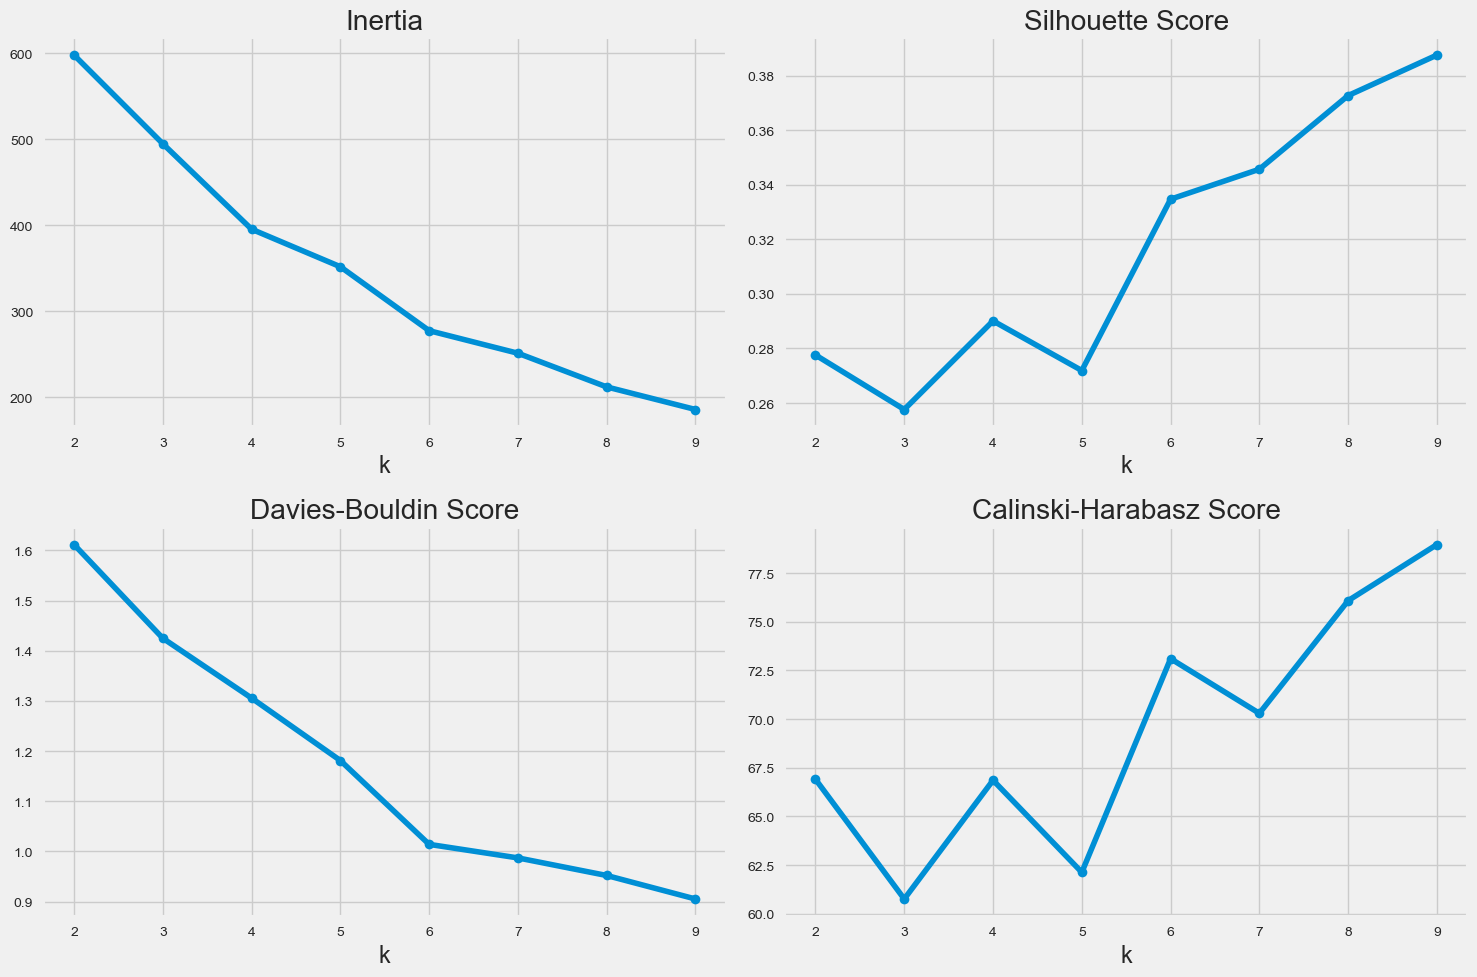

In [92]:
# Plot metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics_df['inertia'].plot(ax=axes[0, 0], title='Inertia', marker='o')
metrics_df['silhouette'].plot(ax=axes[0, 1], title='Silhouette Score', marker='o')
metrics_df['davies_bouldin'].plot(ax=axes[1, 0], title='Davies-Bouldin Score', marker='o')
metrics_df['calinski_harabasz'].plot(ax=axes[1, 1], title='Calinski-Harabasz Score', marker='o')
plt.tight_layout()
plt.show()

In [93]:
# Based on the analysis, let's choose k=6
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

In [94]:
# Add cluster labels to original data
df['Cluster'] = clusters

In [95]:
# Cluster statistics
cluster_stats = df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
print("\nCluster Statistics:")
print(cluster_stats)


Cluster Statistics:
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        57.214286           46.785714               38.714286
1        39.000000           88.333333               14.428571
2        28.410256           58.230769               70.717949
3        33.206897           91.034483               72.137931
4        25.888889           41.277778               57.944444
5        49.914894           54.255319               36.531915


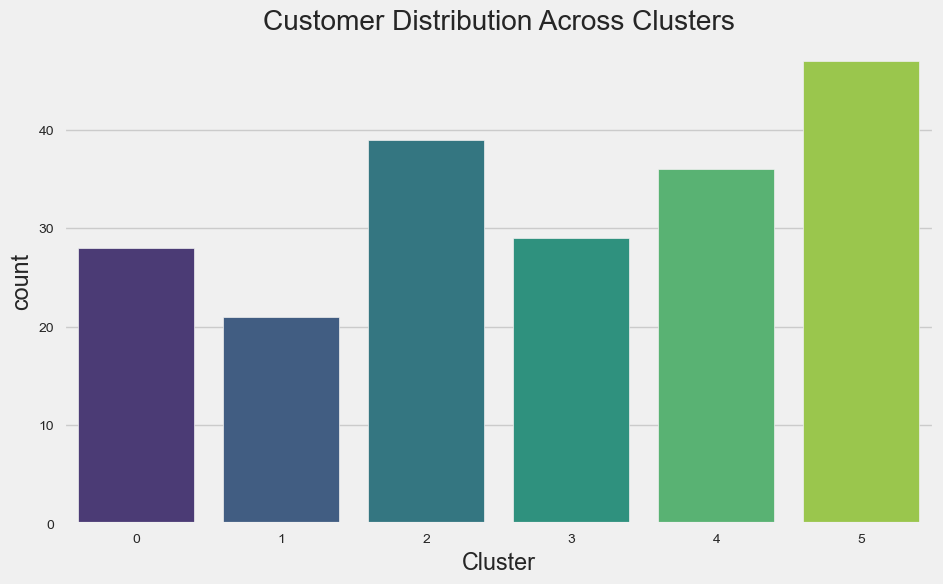

In [96]:
# Count of customers in each cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Cluster', palette='viridis')
plt.title('Customer Distribution Across Clusters')
plt.show()

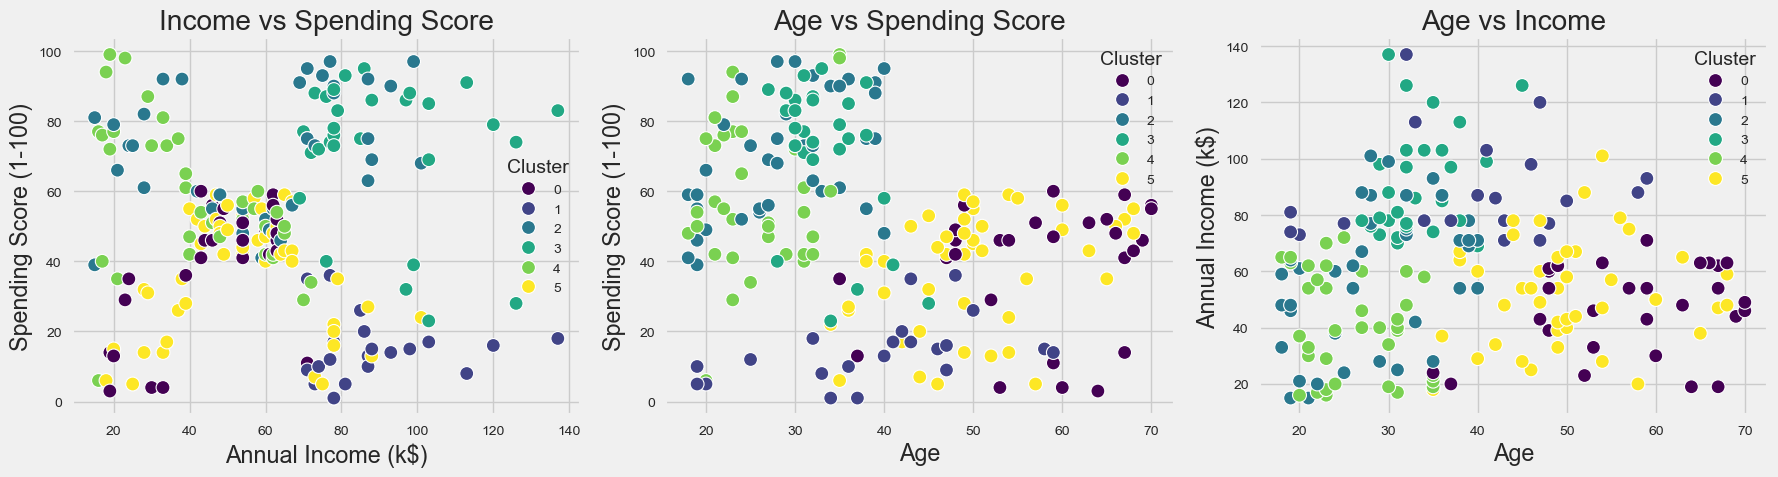

In [97]:
# 2D Scatter plots
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', palette='viridis', s=100)
plt.title('Income vs Spending Score')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Cluster', palette='viridis', s=100)
plt.title('Age vs Spending Score')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x='Age', y='Annual Income (k$)',
                hue='Cluster', palette='viridis', s=100)
plt.title('Age vs Income')

plt.tight_layout()
plt.show()

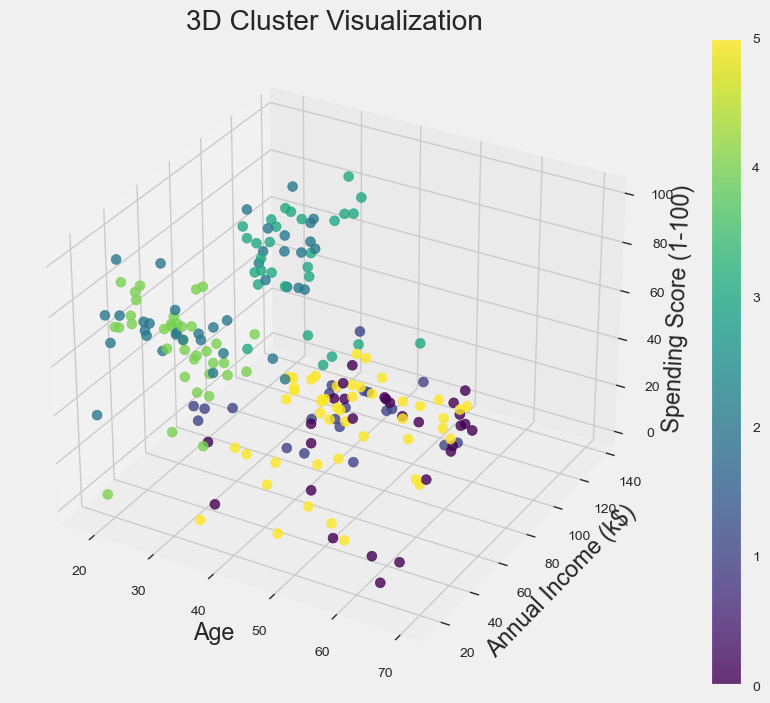

In [98]:
# 3D Visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'],
                    c=df['Cluster'], s=50, cmap='viridis', alpha=0.8)

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D Cluster Visualization')
plt.colorbar(scatter)
plt.show()

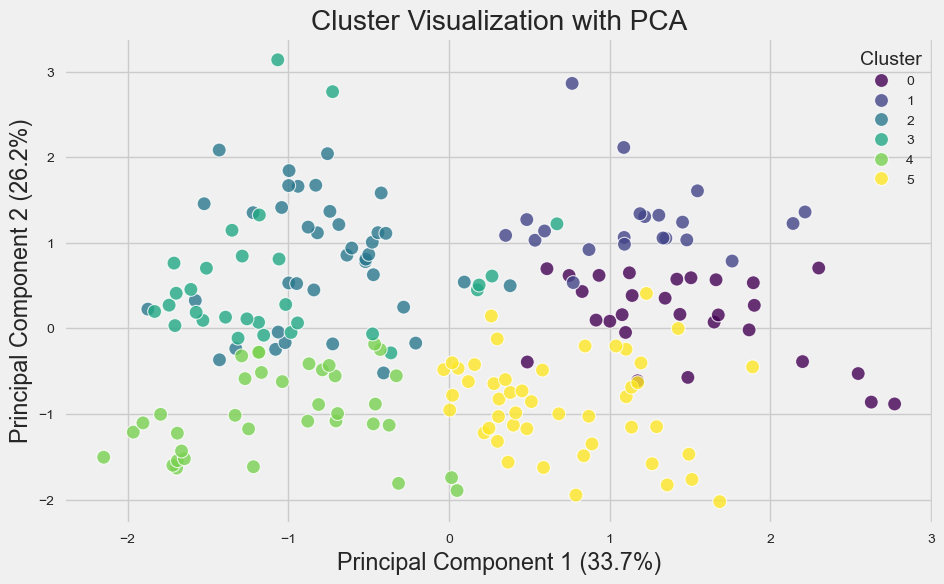

In [99]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster',
               palette='viridis', s=100, alpha=0.8)
plt.title('Cluster Visualization with PCA')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.show()

In [107]:
# First, add the cluster labels to BOTH DataFrames
df['Cluster'] = clusters  # Original data
X_scaled_df['Cluster'] = clusters  # Processed features (includes Gender_Male)

In [108]:
# Now perform cluster analysis using the appropriate DataFrame for each feature
cluster_profile = pd.concat([
    # Numeric features from original data
    df.groupby('Cluster').agg({
        'Age': ['mean', 'median', 'std'],
        'Annual Income (k$)': ['mean', 'median', 'std'],
        'Spending Score (1-100)': ['mean', 'median', 'std']
    }),
    # Encoded features from processed data
    X_scaled_df.groupby('Cluster').agg({
        'Gender_Male': lambda x: (x.sum()/len(x))*100  # Percentage of males
    })
], axis=1).round(2)

In [109]:
# Clean up column names
cluster_profile.columns = ['_'.join(col).strip() for col in cluster_profile.columns.values]
cluster_profile = cluster_profile.rename(columns={
    'Gender_Male_<lambda>': 'Male_percentage'
})

In [110]:
print("\nDetailed Cluster Profiles:")
print(cluster_profile)


Detailed Cluster Profiles:
         Age_mean  Age_median  Age_std  Annual Income (k$)_mean  \
Cluster                                                           
0           57.21        59.0     9.80                    46.79   
1           39.00        41.0    11.55                    88.33   
2           28.41        28.0     7.29                    58.23   
3           33.21        32.0     4.27                    91.03   
4           25.89        24.0     5.21                    41.28   
5           49.91        49.0     8.94                    54.26   

         Annual Income (k$)_median  Annual Income (k$)_std  \
Cluster                                                      
0                             48.5                   15.65   
1                             85.0                   17.32   
2                             61.0                   24.52   
3                             85.0                   18.94   
4                             40.0                   18.10   
5

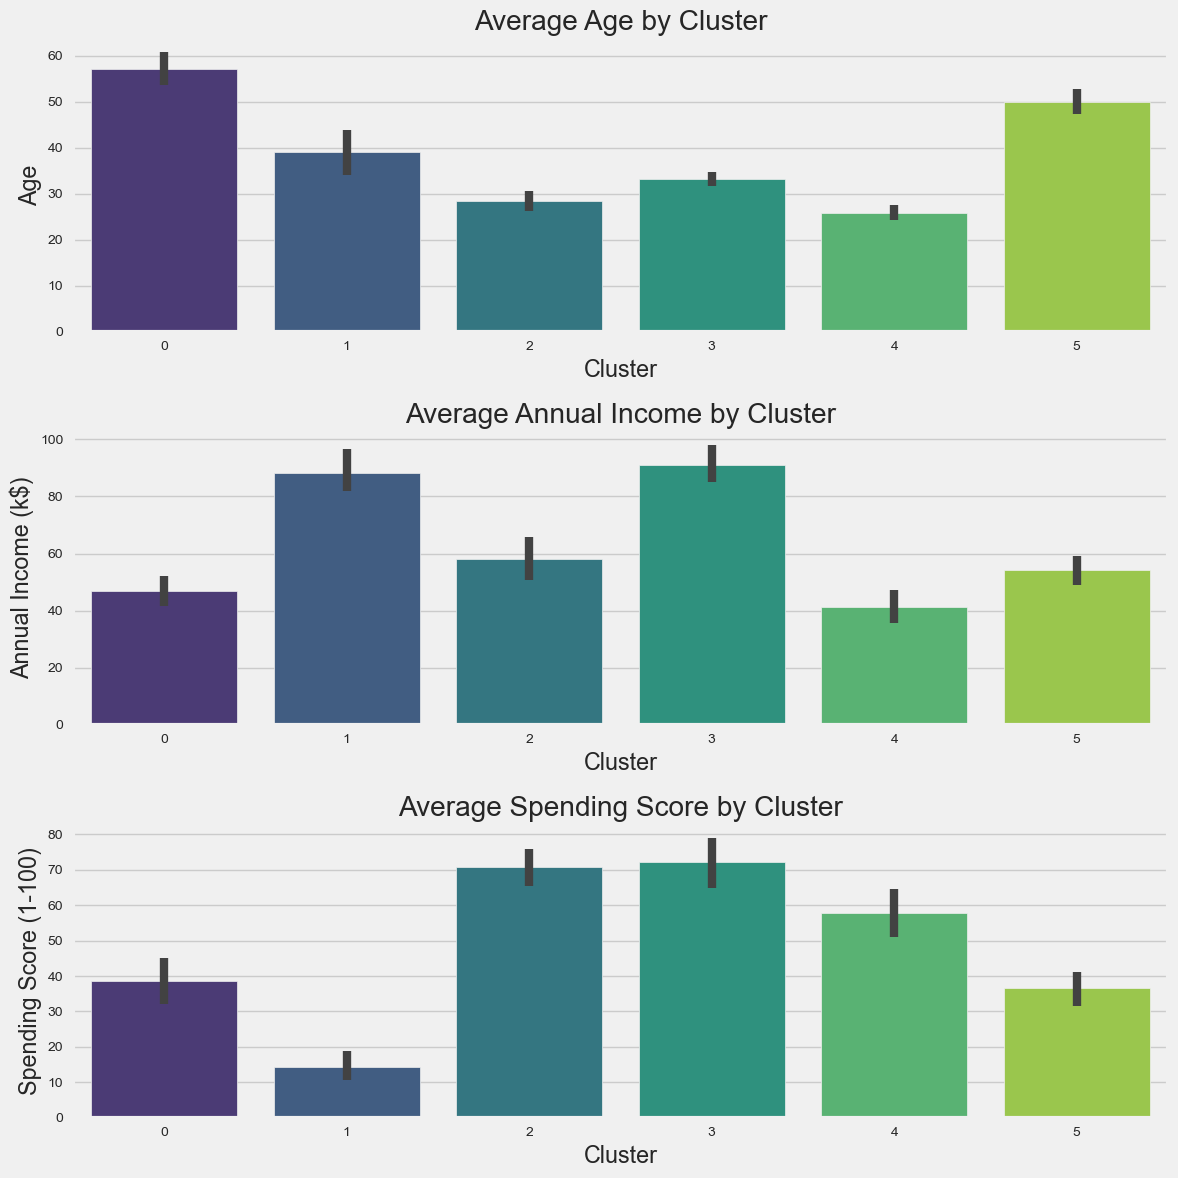

In [111]:
# Visualize cluster characteristics
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

sns.barplot(data=df, x='Cluster', y='Age', ax=axes[0], palette='viridis')
axes[0].set_title('Average Age by Cluster')

sns.barplot(data=df, x='Cluster', y='Annual Income (k$)', ax=axes[1], palette='viridis')
axes[1].set_title('Average Annual Income by Cluster')

sns.barplot(data=df, x='Cluster', y='Spending Score (1-100)', ax=axes[2], palette='viridis')
axes[2].set_title('Average Spending Score by Cluster')

plt.tight_layout()
plt.show()

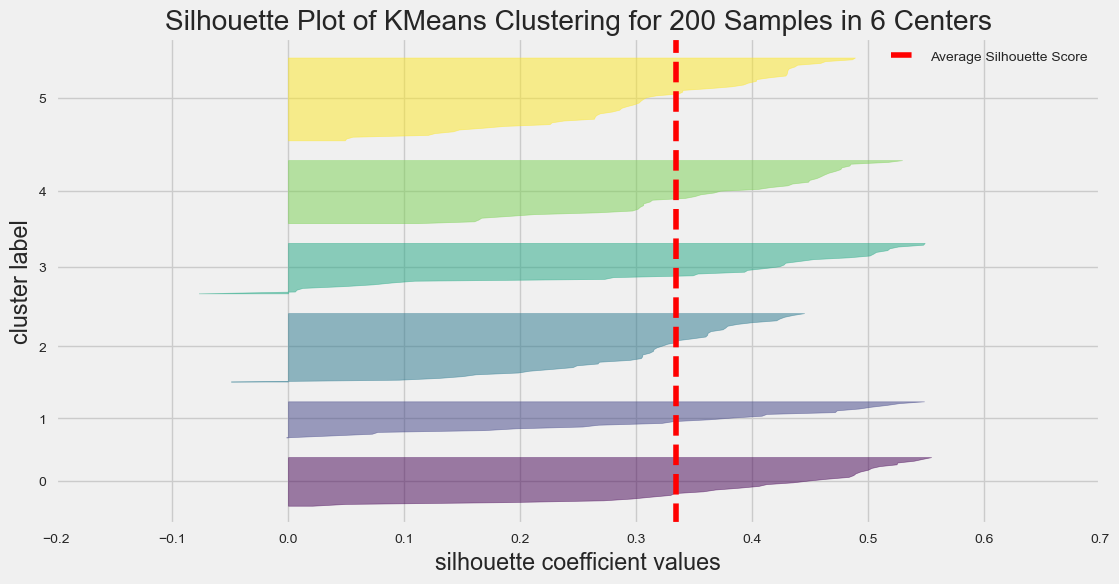

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 200 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [112]:
# Silhouette Plot for Final Clusters
plt.figure(figsize=(12, 6))
visualizer = SilhouetteVisualizer(kmeans, colors='viridis')
visualizer.fit(X_scaled)
visualizer.show()

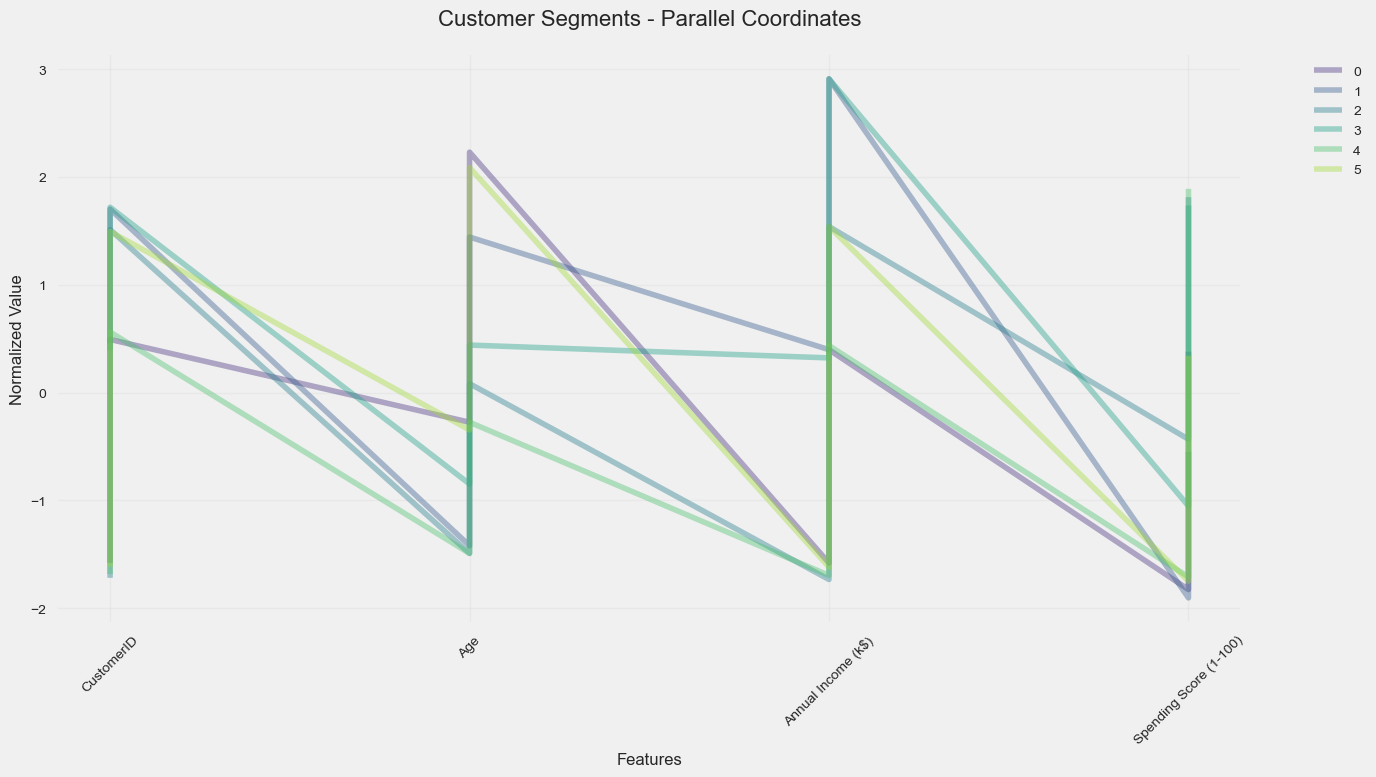

In [127]:
# Parallel Coordinates Plot

# Prepare the data
plot_data = df.copy()
plot_data['Cluster'] = plot_data['Cluster'].astype('category')

# Normalize numeric columns for better visualization
numeric_cols = plot_data.select_dtypes(include=['number']).columns
plot_data[numeric_cols] = (plot_data[numeric_cols] - plot_data[numeric_cols].mean()) / plot_data[numeric_cols].std()

# Melt the data for seaborn
melted = plot_data.melt(id_vars='Cluster', value_vars=numeric_cols)

# Create the plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=melted,
    x='variable',
    y='value',
    hue='Cluster',
    units='Cluster',
    estimator=None,
    palette='viridis',
    alpha=0.4
)

plt.title('Customer Segments - Parallel Coordinates', pad=20, size=16)
plt.xlabel('Features', size=12)
plt.ylabel('Normalized Value', size=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()